In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import h5py
import torch 
import torch.nn.functional as F
#from torch.nn.functional import interpolate

from torch.utils.data import DataLoader

import evidence_loss
import dataloader_utils
import uncertain_fusion
import epipolar_geometry

from sklearn.metrics import ConfusionMatrixDisplay
from torchmetrics import ConfusionMatrix

import numpy as np

## Lightning model definition

In [3]:

class SequenceRoboCup1DFusionModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, epipolar_propagation, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1).to(self.device))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1).to(self.device))
        self.n_classes = out_classes
        
        self.epoch = 0
        self.ignore_class = 0.0 #ignore background class  fr loss function
        
        self.confmat = ConfusionMatrix(num_classes=out_classes, normalize='pred')
        
        self.epipolar_propagation = epipolar_propagation
        
        self.conv_1d = torch.nn.Conv2d(in_channels=2*self.n_classes, out_channels=self.n_classes, kernel_size=1)


    def single_batch_forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask
    
    def forward(self, batch):
        logits_mask0 = self.single_batch_forward( batch["image0"])
        propagate_mask0 = self.epipolar_propagation(logits_mask0, 
                                                     batch['depth0'], 
                                                     batch['translation_old_to_new_camera_frame'],
                                                     batch['rotation_old_to_new_camera_frame'])
        
        logits_mask1 = self.single_batch_forward( batch["image1"])
      
        logits_mask1 = torch.concat((propagate_mask0,logits_mask1), dim=1)
        logits_mask1 = self.conv_1d(logits_mask1)
        return logits_mask1
        
    def shared_step(self, batch, stage):
        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert batch["image0"].ndim == 4
        
        bs, num_channels, height, width = batch["image0"].size()

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        assert height % 32 == 0 and width % 32 == 0

    
        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert batch["mask0"].ndim == 4
        assert batch["mask1"].ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert batch["mask0"].max() <= 255.0 and batch["mask0"].min() >= 0
        assert batch["mask1"].max() <= 255.0 and batch["mask1"].min() >= 0

        
        logits_mask1 = self.forward(batch)
        
        
        #unroll the tensor to single tensor 
        mask1 = batch["mask1"]
        # [batch_size, 1, height, width] -> [batch_size*height*width]
        mask1 = torch.ravel(mask1)      
        #Remove pixels exculding the background loss function
        idx_only_objects = (mask1 != self.ignore_class)
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True       
        mask1 = F.one_hot(mask1.long(), self.n_classes)  # [batch_size*height*width] -> [batch_size*height*width, n_classes]
        
        # [batch_size, n_classes, height, width] -> [batch_size,n_classes, height*width]
        logits_mask1 = logits_mask1.view(bs, self.n_classes, -1)
        #propagate_mask0 = propagate_mask0.view(bs, self.n_classes, -1)
        # [batch_size,n_classes, height*width] -> [batch_size, height*width, n_classes]
        logits_mask1 = logits_mask1.permute(0,2,1)
        #propagate_mask0 = propagate_mask0.permute(0,2,1)
        # [batch_size, height*width, n_classes] -> [batch_size*height*width, n_classes]
        logits_mask1 = logits_mask1.reshape_as(mask1)        
        #propagate_mask0 = propagate_mask0.reshape_as(mask1)        
        
        #Fluctute between all loss and only objects loss excluding bakground
        if (stage == "train"):
            if self.epoch % 2 == 0:
                loss = evidence_loss.edl_mse_loss(logits_mask1, mask1, self.epoch, self.n_classes, 10)
            else:
                loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], mask1[idx_only_objects], self.epoch, self.n_classes, 10)
        else:
            loss = evidence_loss.edl_mse_loss(logits_mask1[idx_only_objects], 
                                              mask1[idx_only_objects], 
                                              self.epoch, self.n_classes, 10)

     
            
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        logits_mask1 = torch.nn.functional.relu(logits_mask1) +  1
        pred_mask = logits_mask1.argmax(dim=1, keepdim=True)
         
        #Changing back to original dimension for metrics calculation
        mask1 = mask1.argmax(dim=1, keepdim=True)
        
        
        
        #Confusion matrix calculation
        confusion_matrix = self.confmat(pred_mask, mask1)
        
        pred_mask = pred_mask.reshape(bs, 1, height, width )
        mask1 = mask1.reshape(bs, 1, height, width)
        
        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(),
                                               mask1.long(), 
                                               mode="multiclass", 
                                               num_classes=self.n_classes)
       
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
            "confusion_matrix":confusion_matrix
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        # then compute metrics with required reduction (see metric docs)
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
        # aggregate step metics
        loss = [x["loss"].item() for x in outputs]
        
        #confusion matrix sum
        self.cm = torch.sum(torch.stack([x["confusion_matrix"] for x in outputs]), dim=0)

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
            f"{stage}_evidential_loss": np.mean(loss)
        }
        
        self.log_dict(metrics, prog_bar=True)
        self.epoch += 1

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## Dataloader

In [4]:
root = '../learning_blenerproc/images_robocup/'

train_dataset = dataloader_utils.SequenceRoboCupDataset(root, "two_sequence")
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=int(16/2))


Found 534 files in the folder
Found 356 two image sequences 
filename  330.hdf5


In [5]:
root = '../learning_blenerproc/images_pose_robocup/'

valid_dataset = dataloader_utils.SequenceRoboCupDataset(root, "two_sequence")
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=int(16/2))



Found 150 files in the folder
Found 100 two image sequences 
filename  0000.hdf5


In [6]:
epipolar_propagation = epipolar_geometry.EpipolarPropagation(valid_dataset.K, 
                                           valid_dataset.Kinv, 
                                           valid_dataset.height, 
                                           valid_dataset.width, 
                                           fill_empty_with_ones=False)


cuda


In [9]:
model = SequenceRoboCup1DFusionModel("FPN", "timm-mobilenetv3_small_minimal_100", 
                             in_channels=3, out_classes=6,
                            epipolar_propagation=epipolar_propagation)
#model.model = torch.load('uncertain_semantic_mobilenetv3_200epoch.pt')
model.model = torch.load('uncertain_semantic_mobilenetv3_fusion.pt')
model.model = model.model.requires_grad_(False)


In [10]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=50,
)

trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)
# run validation dataset
#valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
#print(valid_metrics)
#pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                | Params
-------------------------------------------------------------
0 | model                | FPN                 | 2.2 M 
1 | confmat              | ConfusionMatrix     | 0     
2 | epipolar_propagation | EpipolarPropagation | 0     
3 | conv_1d              | Conv2d              | 78    
-------------------------------------------------------------
78        Trainable params
2.2 M     Non-trainable params
2.2 M     Total params
8.898     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
cm = model.cm.cpu().detach().numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



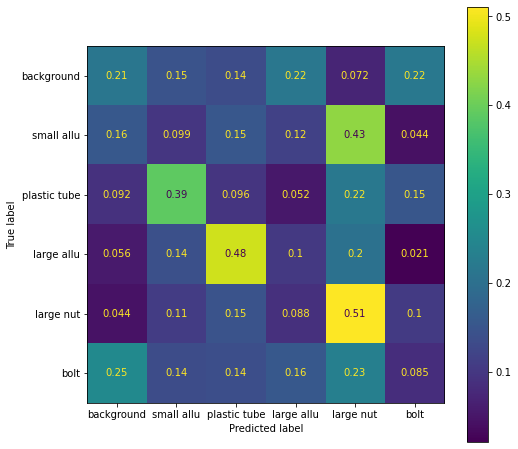

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(cm, display_labels=list(valid_dataset.class_names.values()))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

In [13]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_per_image_iou': 0.6307293176651001, 'valid_dataset_iou': 0.624743640422821, 'valid_evidential_loss': 1.2011655569076538}]


NameError: name 'pprint' is not defined

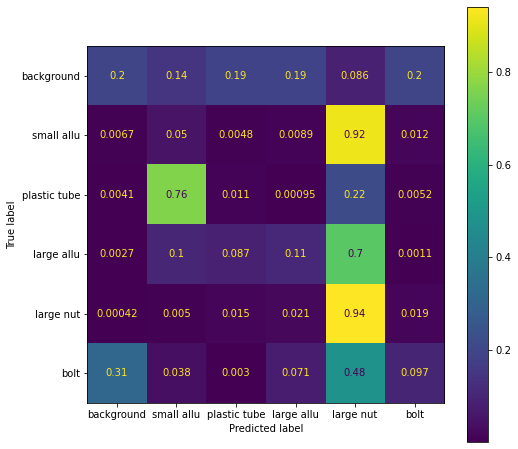

In [14]:
cm = model.cm.cpu().detach().numpy()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm, display_labels=list(valid_dataset.class_names.values()))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
plt.show()

Max confidence per batch :  torch.return_types.max(
values=tensor([83.6404, 98.3470], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([1282651,  434505], device='cuda:0'))
Max uncertainty per batch :  torch.return_types.max(
values=tensor([1., 1.], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 0], device='cuda:0'))
torch.Size([2, 1, 512, 512])


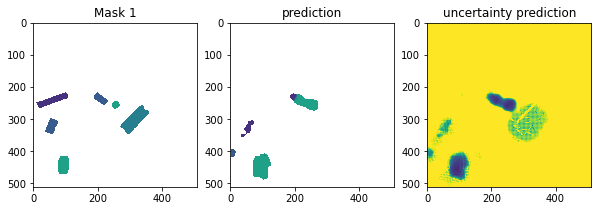

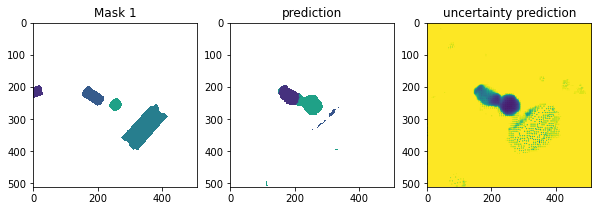

In [16]:
import matplotlib.pyplot as plt

batch = next(iter(valid_dataloader))
device = 'cuda'
batch['image1'] = batch['image1'].to(device)
batch['image0'] = batch['image0'].to(device)
batch['mask1'] = batch['mask1'].to(device)
batch['mask0'] = batch['mask0'].to(device)
bs, dim, h, w = batch['image1'].shape
model = model.to('cuda')
logits_image1 = model(batch)
logits_image1 = torch.nn.functional.relu(logits_image1) +  1
sum_evidence = torch.sum(logits_image1, dim=1, keepdim=True)
uncertainty = 6 / sum_evidence
print ("Max confidence per batch : ", torch.max(logits_image1.view(bs,-1), dim=1))
print ("Max uncertainty per batch : ", torch.max(uncertainty.view(bs,-1), dim=1))

logits_image1 = logits_image1.argmax(dim=1, keepdim=True)
print (logits_image1.shape)

for prev_image, curr_image, uncert in zip(batch["mask1"], logits_image1, uncertainty):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    data = prev_image.cpu().detach().numpy().squeeze()  # convert CHW -> HWC
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Mask 1")
    #plt.axis("off")

    plt.subplot(1, 3, 2)
    data = curr_image.cpu().detach().numpy().squeeze()  # convert CHW -> HWC
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("prediction")

    plt.subplot(1, 3, 3)
    data = uncert.cpu().detach().numpy().squeeze()
    plt.imshow(data)# just squeeze classes dim, because we have only one class
    plt.title("uncertainty prediction")
    #plt.axis("off")



    plt.show()
        
        


In [1]:
import torchvision

In [33]:
# log sampled images
sample_imgs = batch["mask1"]
grid = torchvision.utils.make_grid(sample_imgs)
#self.logger.experiment.add_image('generated_images', grid, 0)

## Dataloader on images_robocup folder with new images

In [18]:
root = '../learning_blenerproc/images_robocup/'

train_dataset = dataloader_utils.SequenceRoboCupDataset(root, "two_sequence")
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=int(16/2))


Found 534 files in the folder
Found 356 two image sequences 
filename  330.hdf5


In [49]:
for batch in valid_dataset:
    pass


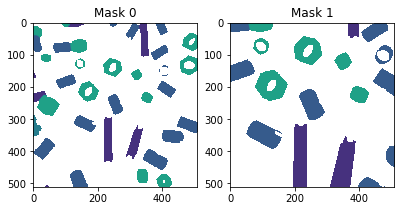

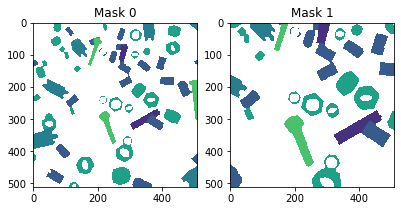

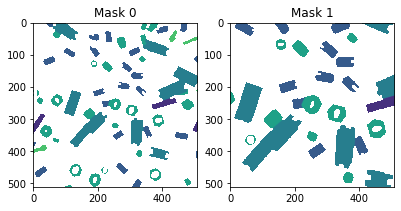

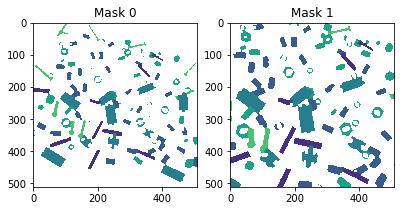

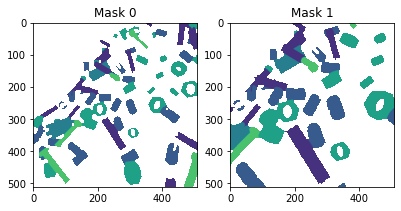

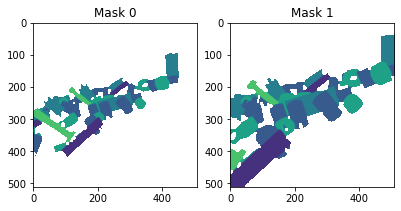

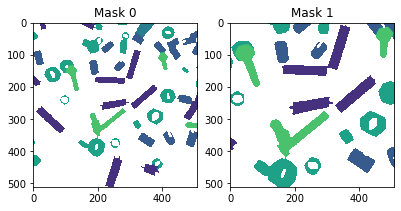

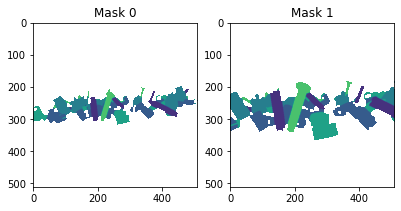

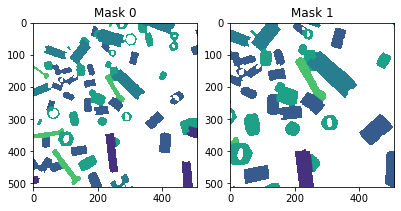

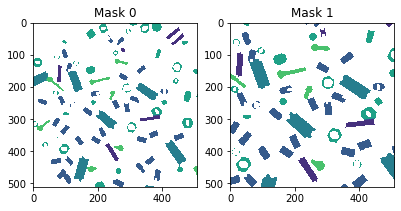

In [40]:
import matplotlib.pyplot as plt
batch = next(iter(valid_dataloader))

for prev_image, curr_image in zip(batch["mask0"], batch["mask1"]):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    data = prev_image.numpy().squeeze()  # convert CHW -> HWC
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Mask 0")
    #plt.axis("off")

    plt.subplot(1, 3, 2)
    data = curr_image.numpy().squeeze()  # convert CHW -> HWC
    data = np.ma.masked_where((0.0 == data), data)
    plt.imshow(data, vmin=0, vmax=7)# just squeeze classes dim, because we have only one class
    plt.title("Mask 1")
    #plt.axis("off")

    
  
    plt.show()

In [30]:
valid_dataset.print_filenames()

[['330.hdf5', '331.hdf5'],
 ['331.hdf5', '332.hdf5'],
 ['333.hdf5', '334.hdf5'],
 ['334.hdf5', '335.hdf5'],
 ['336.hdf5', '337.hdf5'],
 ['337.hdf5', '338.hdf5'],
 ['339.hdf5', '340.hdf5'],
 ['340.hdf5', '341.hdf5'],
 ['342.hdf5', '343.hdf5'],
 ['343.hdf5', '344.hdf5'],
 ['345.hdf5', '346.hdf5'],
 ['346.hdf5', '347.hdf5'],
 ['348.hdf5', '349.hdf5'],
 ['349.hdf5', '350.hdf5'],
 ['351.hdf5', '352.hdf5'],
 ['352.hdf5', '353.hdf5'],
 ['354.hdf5', '355.hdf5'],
 ['355.hdf5', '356.hdf5'],
 ['357.hdf5', '358.hdf5'],
 ['358.hdf5', '359.hdf5'],
 ['360.hdf5', '361.hdf5'],
 ['361.hdf5', '362.hdf5'],
 ['363.hdf5', '364.hdf5'],
 ['364.hdf5', '365.hdf5'],
 ['366.hdf5', '367.hdf5'],
 ['367.hdf5', '368.hdf5'],
 ['369.hdf5', '370.hdf5'],
 ['370.hdf5', '371.hdf5'],
 ['372.hdf5', '373.hdf5'],
 ['373.hdf5', '374.hdf5'],
 ['375.hdf5', '376.hdf5'],
 ['376.hdf5', '377.hdf5'],
 ['378.hdf5', '379.hdf5'],
 ['379.hdf5', '380.hdf5'],
 ['381.hdf5', '382.hdf5'],
 ['382.hdf5', '383.hdf5'],
 ['384.hdf5', '385.hdf5'],
 

In [37]:
torch.save(model.model, 'uncertain_semantic_mobilenetv3_fusion.pt')